In [147]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math, copy
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

In [148]:
def datetime_to_hour(x):
    return x.hour

# visualize categorical variables
def barplots(pdSeries):
    x = pdSeries.value_counts()
    plt.figure(figsize=(20, 5))
    sns.barplot(x.index, x.values)

# visualize categorical variables
def distplots(pdSeries):
    plt.figure(figsize=(20, 3))
    sns.distplot(pdSeries)

def cross_heatmap(data, exp_val, tar_val):
    crossmat = pd.crosstab(data[exp_val], data[tar_val], normalize='index')
    sns.heatmap(crossmat, annot=True, fmt='.3f', cmap='Blues')



In [149]:
df_origin = pd.read_csv('ks-projects-201801.csv')

In [150]:
df_origin.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


# Data processing
参考：
[【データ分析】新規データを受領したら最初にすべき10ステップ \- Qiita](https://qiita.com/takubb/items/e18ea4f7c4ecc8be4a5f)

In [151]:
df = df_origin

# generate target variable
# df['is_successful'] = 0
# df.loc[df['state']=='successful', 'is_successful'] = 1

# exclude: ID, name, goal, pledged, usd pledged, use_pledged_real, backers
df = df.drop(['name', 'ID', 'goal', 'pledged', 'usd pledged', 'usd_pledged_real', 'backers'], axis=1)
# df = df.drop(['state'], axis=1)
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')]

# currency to country
# df.loc[(df['country']=='N,0"') & (df['currency']!="EUR"), 'country'] = df.loc[(df['country']=='N,0"') & (df['currency']!="EUR"), 'currency'].str[:2]
# df.loc[(df['country']=='N,0"') & (df['currency']=="EUR"), 'country'] = "EU"
# df = df.drop('currency', axis=1)

# make 'deadline' & 'launched' computable
df.loc[:, ['deadline', 'launched']] = df.loc[:, ['deadline', 'launched']].apply(pd.to_datetime)

# calculate project duration & time-zone of launch
# df['period'] = (df['deadline'] - df['launched'])
df['launched_time'] = df['launched'].apply(datetime_to_hour)


df.describe(include='all')

c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


,category,main_category,currency,deadline,launched,state,country,usd_goal_real,launched_time
count,331675,331675,331675,331675,331675,331675,331675,3.316750e+05,331675.000000
unique,159,15,14,3102,331255,2,23,NaN,NaN
top,Product Design,Film & Video,USD,2014-08-08 00:00:00,2013-04-07 23:30:18,failed,US,NaN,NaN
freq,18680,56527,261511,612,2,197719,261360,NaN,NaN
first,NaN,NaN,NaN,2009-05-03 00:00:00,2009-04-21 21:02:48,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2018-01-02 00:00:00,2017-12-29 03:22:32,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.151000e+04,13.087393
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.108930e+06,7.715456
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e-02,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+03,5.000000


### 単変量データの確認
#### categorical variables

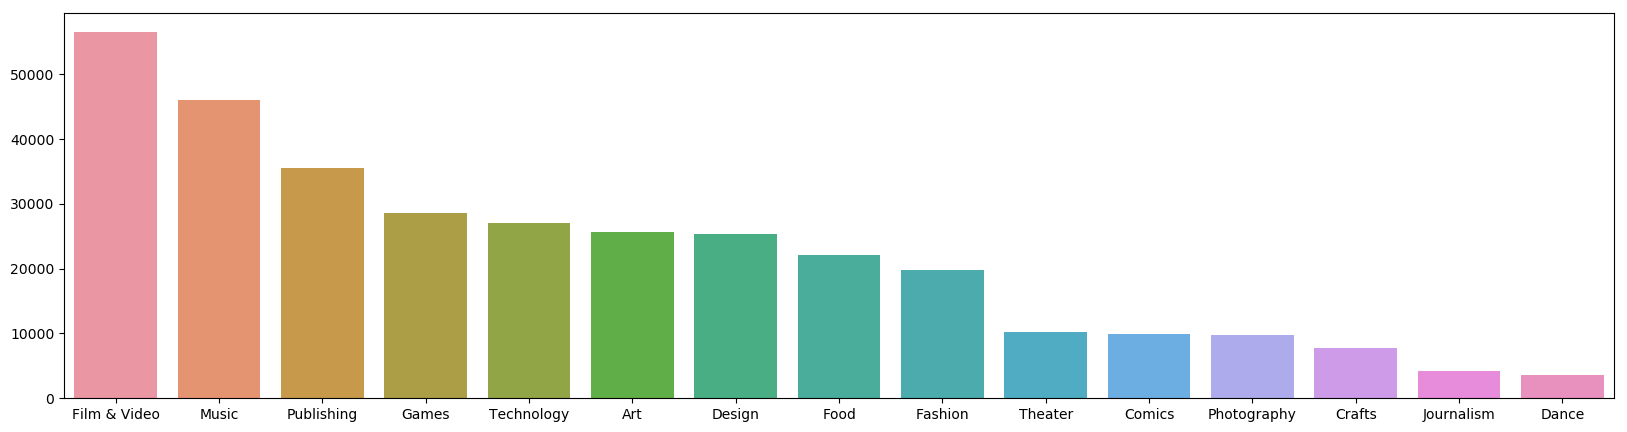

In [152]:
# main category
barplots(df['main_category'])

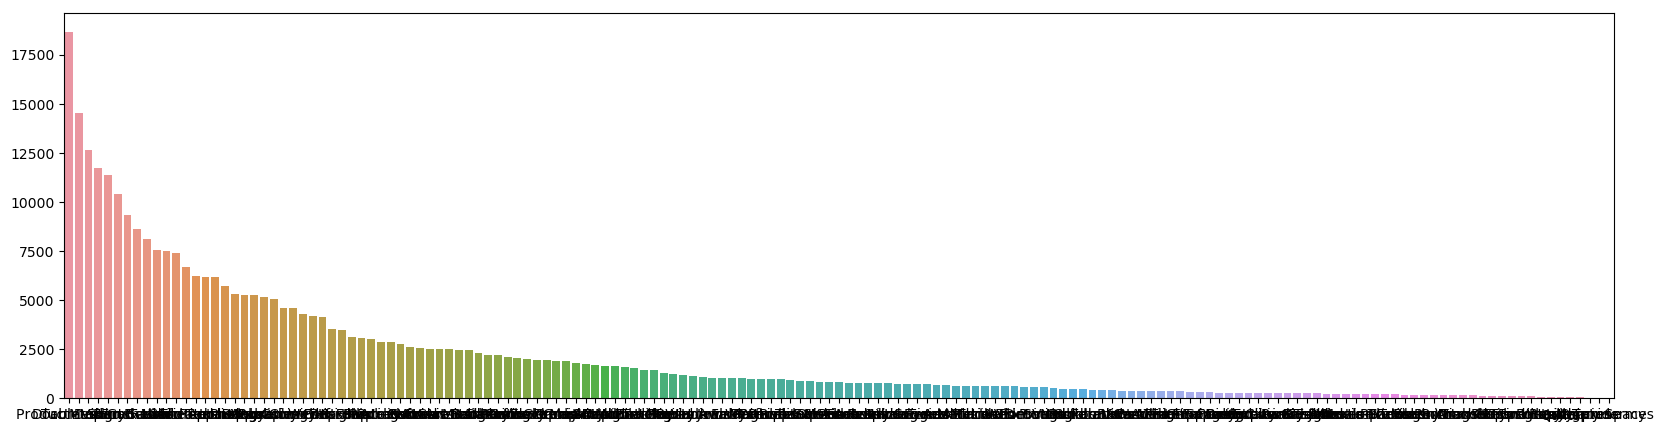

In [153]:
barplots(df['category'])

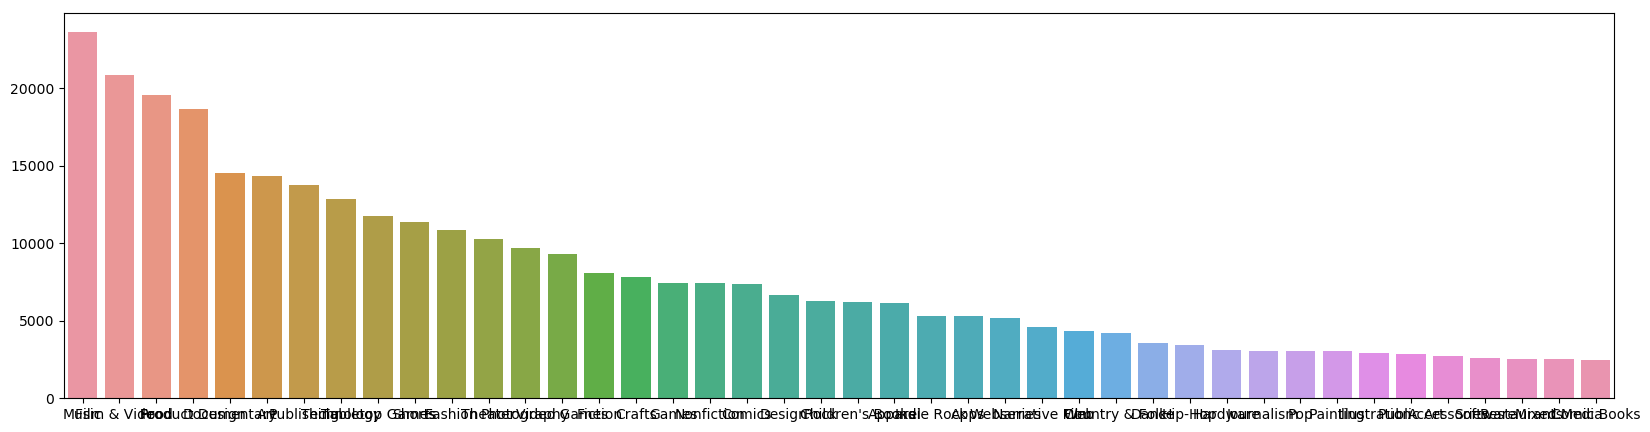

In [154]:
# Replace with 'main_category' if the freq. is too small
x = df['category'].value_counts()
thres = x.describe()['75%']
obj_to_replace = x.index[x.values < thres]
df.loc[df['category'].isin(obj_to_replace), 'category'] = df.loc[df['category'].isin(obj_to_replace), 'main_category']

barplots(df['category'])

(DE      3436
 FR      2520
 NL      2411
 IT      2369
 ES      1873
 SE      1509
 MX      1411
 NZ      1274
 DK       926
 IE       683
 CH       652
 NO       582
 BE       523
 AT       485
 HK       477
 SG       454
 N,0"     210
 LU        57
 JP        23
 Name: country, dtype: int64,
 DE      3436
 FR      2520
 NL      2411
 IT      2369
 ES      1873
 SE      1509
 MX      1411
 NZ      1274
 DK       926
 IE       683
 CH       652
 NO       582
 BE       523
 AT       485
 HK       477
 SG       454
 N,0"     210
 Name: country, dtype: int64)

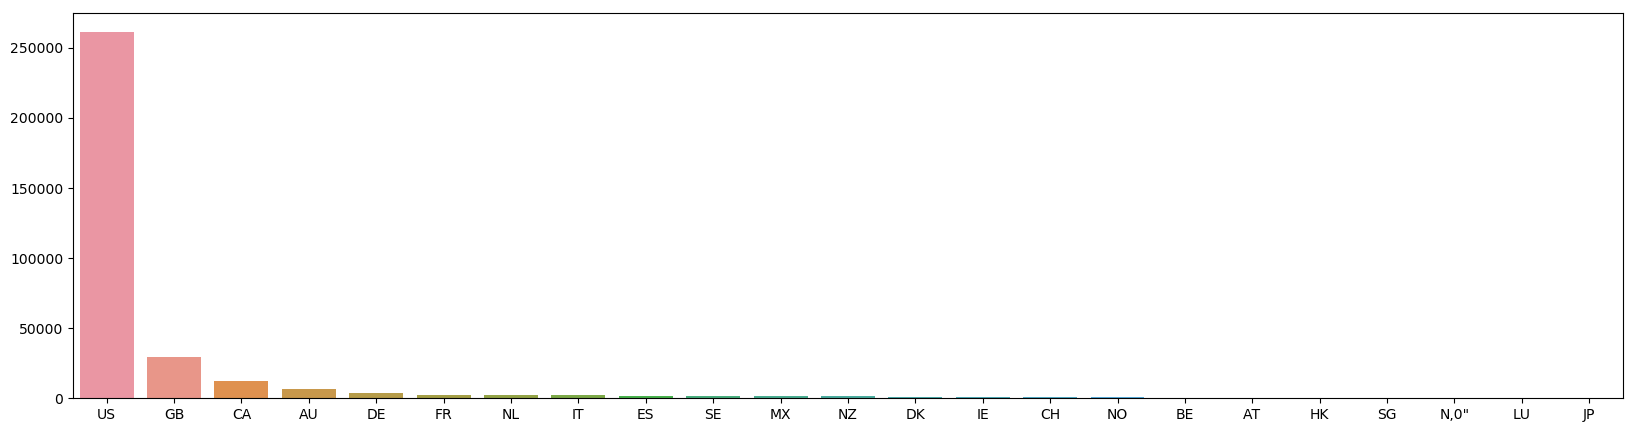

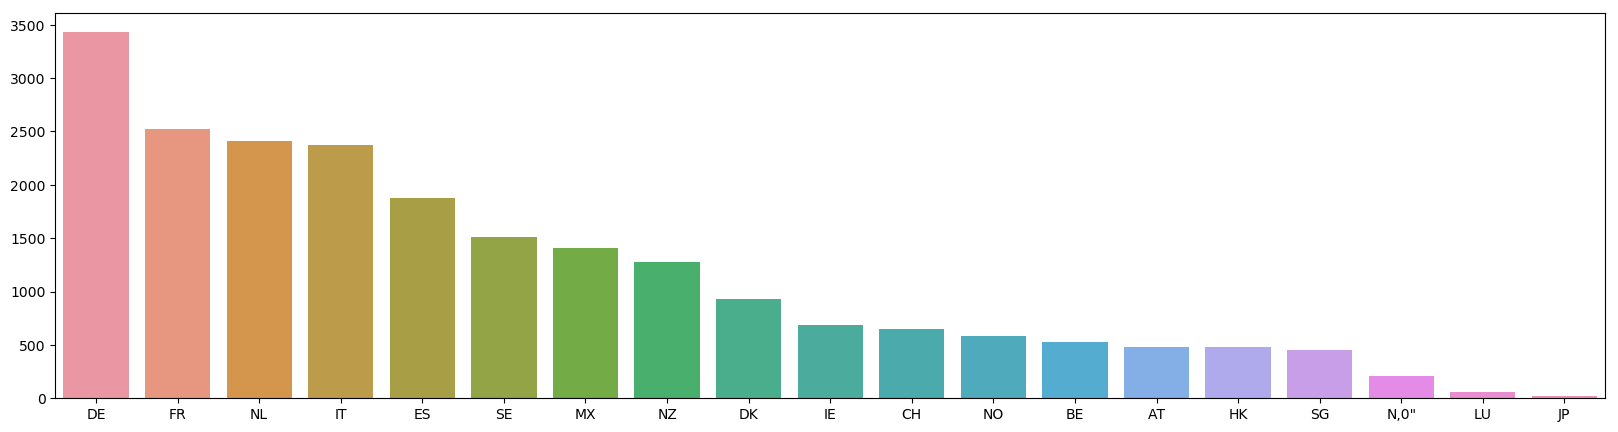

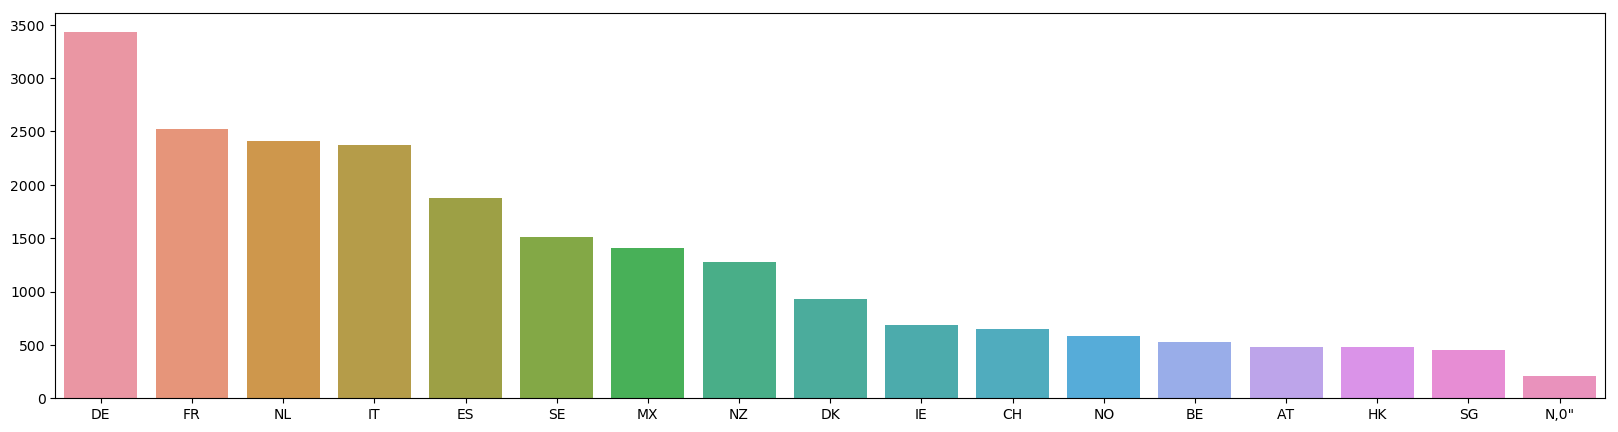

In [155]:
barplots(df['country'])
x = df.loc[~df['country'].isin(['US', 'GB', 'CA', 'AU']), 'country']
barplots(x)

# exclude LU & JP, since they have too small counts.
df = df.loc[~df['country'].isin(['LU','JP']), :] 
x_aft = df.loc[~df['country'].isin(['US', 'GB', 'CA', 'AU']), 'country']
barplots(x_aft)

x.value_counts(), x_aft.value_counts() 

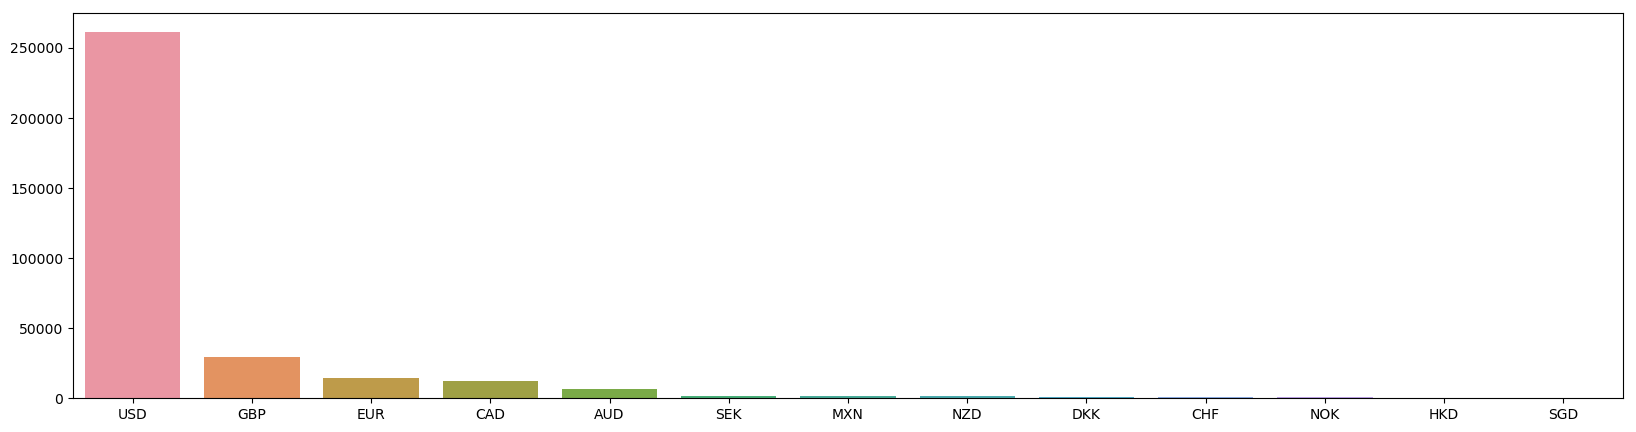

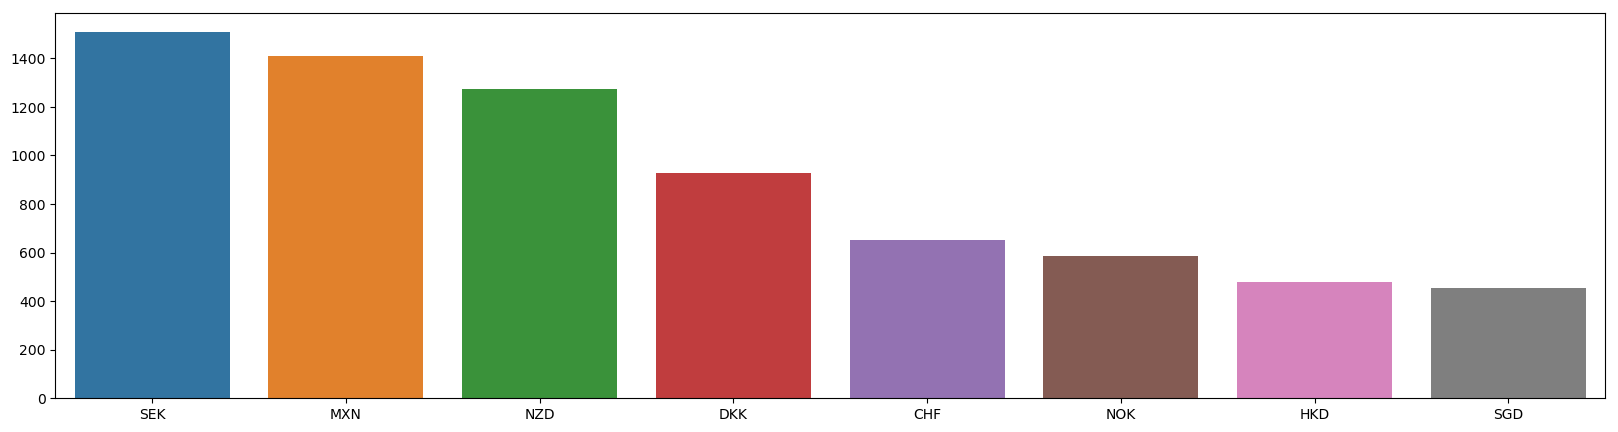

In [156]:
barplots(df['currency'])

x = df.loc[~df['currency'].isin(['USD', 'GBP', 'EUR', 'CAD', 'AUD']), 'currency']
barplots(x)

# it seems to be not necessary to remove data.

#### quantitative variables

In [157]:
# convert datetime objects to integers
def datetime_to_int(pdSeries):
    values = (pdSeries - pdSeries.min()).dt.total_seconds()
    return values

df['deadline'] = datetime_to_int(df['deadline'])
df['launched'] = datetime_to_int(df['launched'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


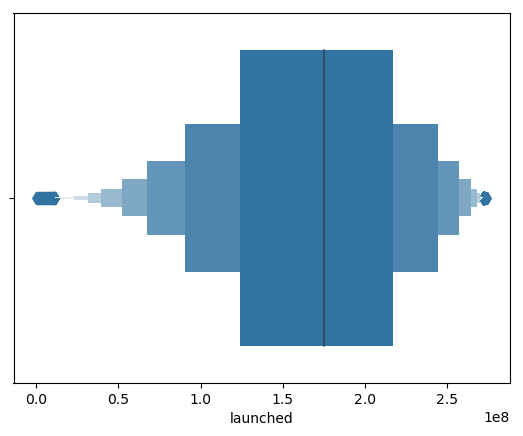

In [158]:
x = df['launched']
x.value_counts(), sns.boxenplot(x)

# remove data that have too small launched values
# df: 378559 rows × 8 columns
df = df.loc[df['launched']!=0, :]
# df: 378552 rows × 8 columns

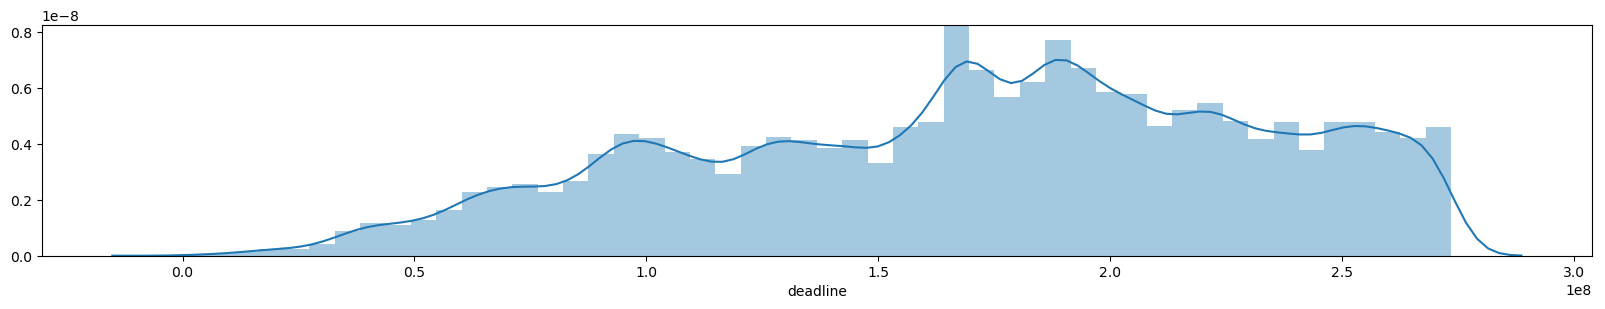

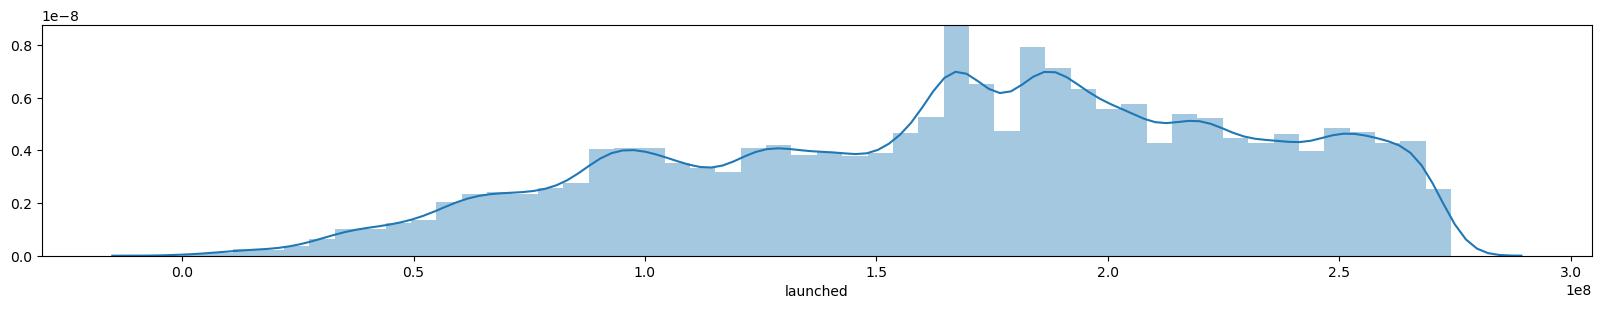

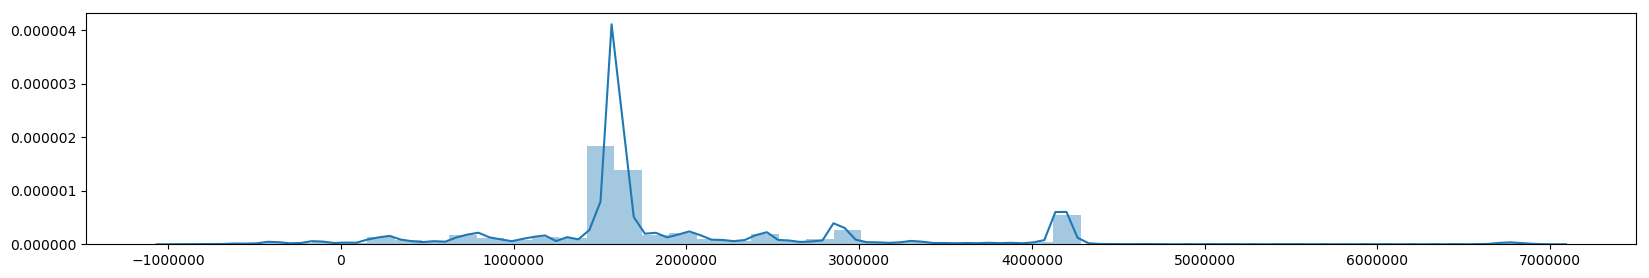

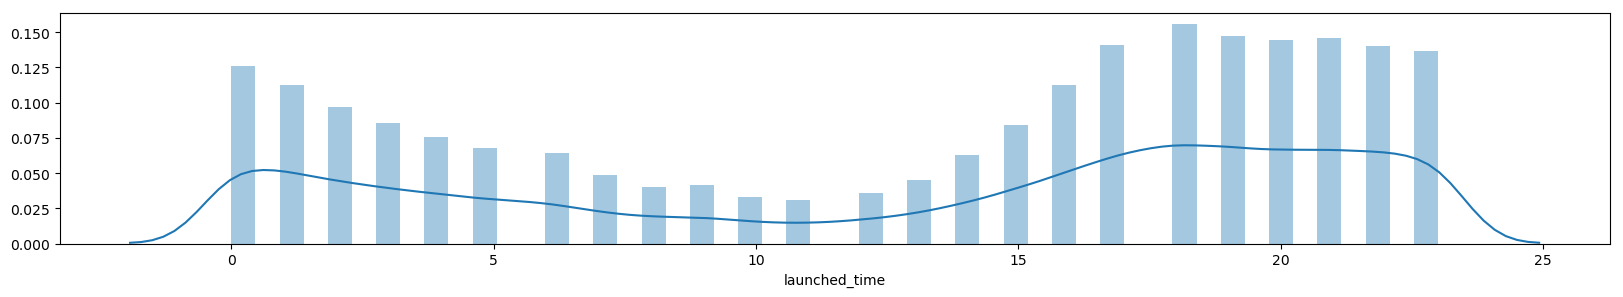

In [159]:
distplots(df['deadline'])
distplots(df['launched'])
distplots(df['deadline'] - df['launched'])

distplots(df['launched_time'])


In [160]:
df.describe(include='all')


,category,main_category,currency,deadline,launched,state,country,usd_goal_real,launched_time
count,331594,331594,331594,3.315940e+05,3.315940e+05,331594,331594,3.315940e+05,331594.000000
unique,42,15,13,NaN,NaN,2,21,NaN,NaN
top,Music,Film & Video,USD,NaN,NaN,failed,US,NaN,NaN
freq,23647,56525,261510,NaN,NaN,197664,261359,NaN,NaN
mean,NaN,NaN,NaN,1.712262e+08,1.693024e+08,NaN,NaN,4.151341e+04,13.087378
std,NaN,NaN,NaN,6.057868e+07,6.076171e+07,NaN,NaN,1.109065e+06,7.715771
min,NaN,NaN,NaN,0.000000e+00,9.750500e+04,NaN,NaN,1.000000e-02,0.000000
25%,NaN,NaN,NaN,1.260576e+08,1.242395e+08,NaN,NaN,2.000000e+03,5.000000
50%,NaN,NaN,NaN,1.766880e+08,1.748825e+08,NaN,NaN,5.000000e+03,16.000000
75%,NaN,NaN,NaN,2.187648e+08,2.169764e+08,NaN,NaN,1.500000e+04,20.000000


## Visualize correlations
#### visualize quantitative variables

In [161]:
# sns.pairplot(data=df, hue='state', plot_kws={"s":10, "alpha":0.7, "linewidth":0.2, "edgecolor":"white"})

c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


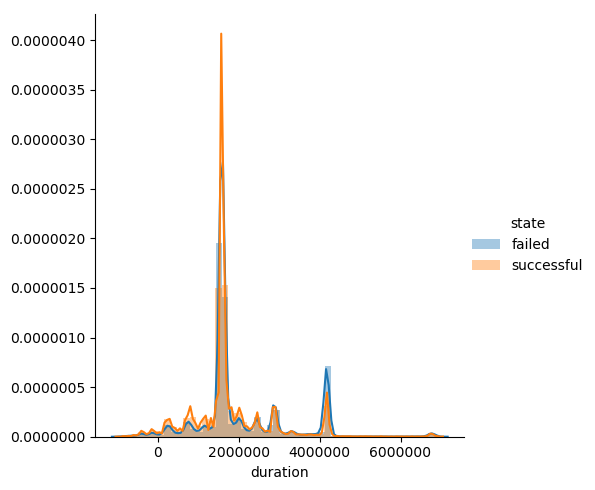

In [162]:
d = df[['state', 'deadline', 'launched']]
d['duration'] = d['deadline'] - d['launched']

g = sns.FacetGrid(data=d, hue='state', size=5)
g.map(sns.distplot, 'duration')
g.add_legend()

#### visualize categorical variables

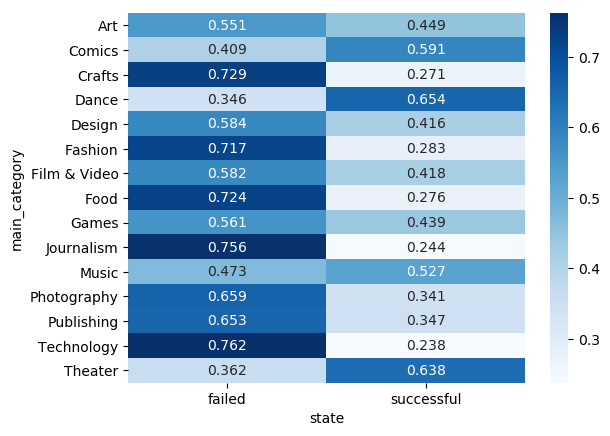

In [163]:
cross_heatmap(df, 'main_category', 'state')

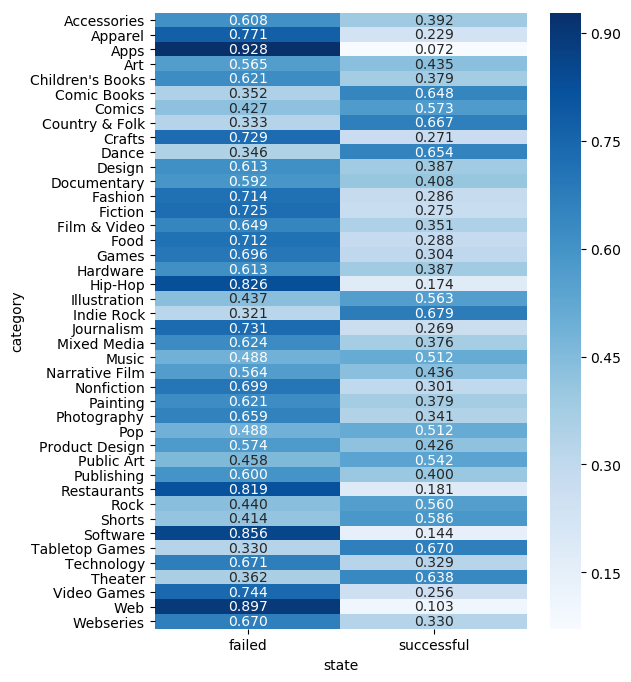

In [164]:
plt.figure(figsize=(6, 8))
cross_heatmap(df, 'category', 'state')

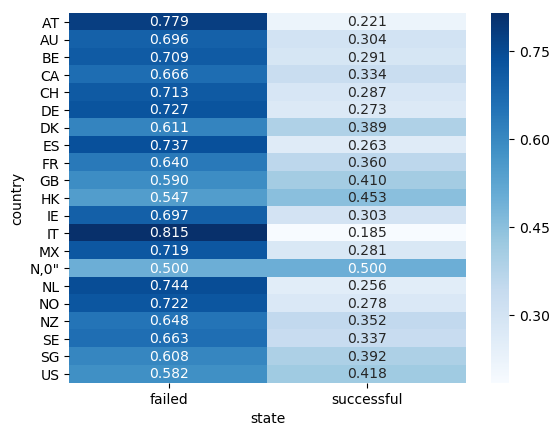

In [165]:
cross_heatmap(df, 'country', 'state')

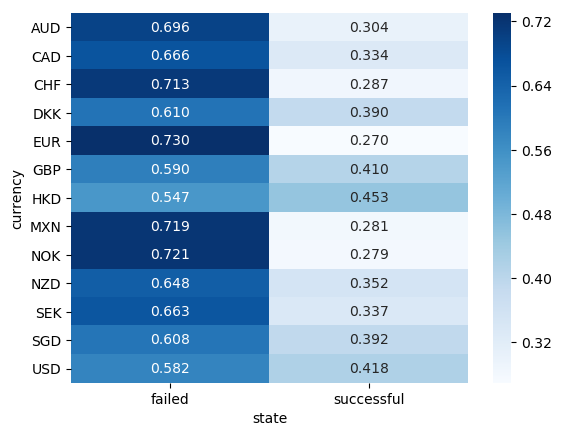

In [166]:
cross_heatmap(df, 'currency', 'state')

In [167]:
df.describe(include='all')

,category,main_category,currency,deadline,launched,state,country,usd_goal_real,launched_time
count,331594,331594,331594,3.315940e+05,3.315940e+05,331594,331594,3.315940e+05,331594.000000
unique,42,15,13,NaN,NaN,2,21,NaN,NaN
top,Music,Film & Video,USD,NaN,NaN,failed,US,NaN,NaN
freq,23647,56525,261510,NaN,NaN,197664,261359,NaN,NaN
mean,NaN,NaN,NaN,1.712262e+08,1.693024e+08,NaN,NaN,4.151341e+04,13.087378
std,NaN,NaN,NaN,6.057868e+07,6.076171e+07,NaN,NaN,1.109065e+06,7.715771
min,NaN,NaN,NaN,0.000000e+00,9.750500e+04,NaN,NaN,1.000000e-02,0.000000
25%,NaN,NaN,NaN,1.260576e+08,1.242395e+08,NaN,NaN,2.000000e+03,5.000000
50%,NaN,NaN,NaN,1.766880e+08,1.748825e+08,NaN,NaN,5.000000e+03,16.000000
75%,NaN,NaN,NaN,2.187648e+08,2.169764e+08,NaN,NaN,1.500000e+04,20.000000


## generate logistic regression model

In [168]:
scaler = StandardScaler()

clf = SGDClassifier(loss='log',
                    penalty='None',
                    max_iter=1e5,
                    tol=1e3,
                    random_state=1234,
                    fit_intercept=True)


In [169]:
# process learning data
y = pd.get_dummies(df['state'])['successful'].values

quan_columns = ['deadline', 'launched', 'launched_time', 'usd_goal_real']
X1 = df[quan_columns]
X2 = df.drop(quan_columns, axis=1).drop('state', axis=1)

scaler.fit(X1)
X1_scaled = scaler.transform(X1)

X2_dummy = pd.get_dummies(X2).values

X = np.concatenate([X1_scaled, X2_dummy], axis=1)


c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == "__main__":


In [170]:
# learn model
clf.fit(X, y)

# save the model above
import pickle
with open('model.pickle', mode='wb') as f:
    pickle.dump(clf,f,protocol=2)

In [171]:
# load the model saved
with open('model.pickle', mode='rb') as f:
    clf = pickle.load(f)

In [172]:
clf.fit(X, y)
y_est = clf.predict(X)

confmat = pd.DataFrame(confusion_matrix(y, y_est)).rename(columns={0: 'failed_est', 1: 'successful_est'},
                                                          index={0: 'failed_true', 1: 'successful_true'})
confmat

c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\linear_model\base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


,failed_est,successful_est
failed_true,158588,39076
successful_true,72584,61346


In [173]:
ac = accuracy_score(y, y_est)
pr = precision_score(y, y_est)
re = recall_score(y, y_est)

print(f'acurracy: {ac:.3f}, precision: {pr:.3f}, recall: {re:.3f}')

acurracy: 0.663, precision: 0.611, recall: 0.458


1. 最も関係がなさそうな説明変数(launched_time)を除いてみる → 重みほぼゼロだったみたいで何も変わらなかったので削除
2. durationを説明変数に入れてみる
3. goal_usdを対数変換してみる

In [177]:
# 2. Add 'duration' to the explanatories.
X1_2 = copy.copy(X1)
X1_2['duration'] = X1_2['deadline'] - X1_2['launched']

scaler.fit(X1_2.values)
X1_scaled_2 = scaler.transform(X1_2.values)

X_2 = np.concatenate([X1_scaled_2, X2_dummy], axis=1)

clf.fit(X_2, y)
y_est_2 = clf.predict(X_2)

ac = accuracy_score(y, y_est_2)
pr = precision_score(y, y_est_2)
re = recall_score(y, y_est_2)
print(f'acurracy: {ac:.3f}, precision: {pr:.3f}, recall: {re:.3f}')

# Scores did not change.

acurracy: 0.663, precision: 0.609, recall: 0.462


c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\linear_model\base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\linear_model\base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


acurracy: 0.666, precision: 0.616, recall: 0.461


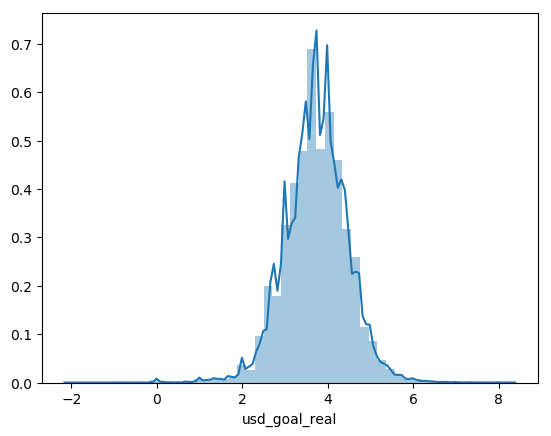

In [178]:
# 3. Convert 'usd_goal_real' into log-scale.
X1_3 = copy.copy(X1)
X1_3['usd_goal_real'] = X1_3['usd_goal_real'].map(math.log10)

sns.distplot(X1_3['usd_goal_real'])

scaler.fit(X1_3.values)
X1_scaled_3 = scaler.transform(X1_3.values)

X_3 = np.concatenate([X1_scaled_3, X2_dummy], axis=1)

clf.fit(X_3, y)
y_est_3 = clf.predict(X_3)

ac = accuracy_score(y, y_est_3)
pr = precision_score(y, y_est_3)
re = recall_score(y, y_est_3)
print(f'acurracy: {ac:.3f}, precision: {pr:.3f}, recall: {re:.3f}')

# Scores have slightly been up.

#### Use only 'successful' or 'failed' data, stop using other data such as 'undefined', 'live', 'suspended', etc.
Before: acurracy: 0.690, precision: 0.587, recall: 0.412
After:  acurracy: 0.666, precision: 0.616, recall: 0.461